In [1]:
!nvidia-smi

Sat Jan  4 20:08:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import Modules




In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add

In [2]:
BASE_DIR ='/content/drive/MyDrive/image_to_text/Dataset'


##Extract image features

In [3]:
#Load VGG16 model
model = VGG16()
#Restructure model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
from re import VERBOSE
#extract feature from image
features={}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
  #Load image from file
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  #convert image pixels to numpy array
  image = img_to_array(image)
  #reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  #preprocess img for vgg
  image = preprocess_input(image)
  #extract features
  feature = model.predict(image, verbose=0)
  #get image id
  image_id = img_name.split('.')[0]
  #store features
  features[image_id] = feature

  0%|          | 0/8101 [00:00<?, ?it/s]

In [ ]:
#store featues in pickle
pickle.dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))

In [5]:
#Load features from pickle
with open(os.path.join(BASE_DIR, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

## Load Caption Data

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()


In [7]:
captions_doc[:100]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1'

In [8]:
#create mapping of image to captions
mapping ={}
#process lines
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extension from image ID
  image_id = image_id.split('.')[0]
  #convert caption list to string
  caption = " ".join(caption)
  #create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  #store the caption
  mapping[image_id].append(caption)



  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

##Preprocess caption


In [10]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      #take one caption at a time
      caption = captions[i]
      #preprocess step
      caption = caption.lower()
      #delete digits, special chars etc
      caption =caption.replace('[^A-Za-z]','')
      #delete additional spaces
      caption = caption.replace('\s+', ' ')
      #add start and end tags to the caption
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption


In [11]:
#before preprocessing
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [12]:
clean(mapping)

In [13]:
#after preprocess
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
all_captions =[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
#get maximum len of the captions
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35


## Train Test split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [47]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize empty lists to hold batch data
    X1, X2, y = [], [], []
    n = 0

    while True:  # Infinite loop to continuously generate data
        for key in data_keys:
            captions = mapping[key]
            # Process each caption for the current image
            for caption in captions:
                # Encode the caption to a sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X and y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence to the maximum length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode the output sequence as categorical
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store the sequences
                    X1.append(features[key][0])  # Image features (vector)
                    X2.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output sequence

                    n += 1
                    if n == batch_size:
                        # Once we have a batch, convert the lists to TensorFlow tensors
                        x1, x2, y = tf.convert_to_tensor(X1, dtype=tf.float32), \
                                    tf.convert_to_tensor(X2, dtype=tf.int32), \
                                    tf.convert_to_tensor(y, dtype=tf.float32)
                        # Yield the data as tensors in the expected format
                        yield ((x1, x2), y)
                        # Reset the lists for the next batch
                        X1, X2, y = [], [], []
                        n = 0


## Model Creation


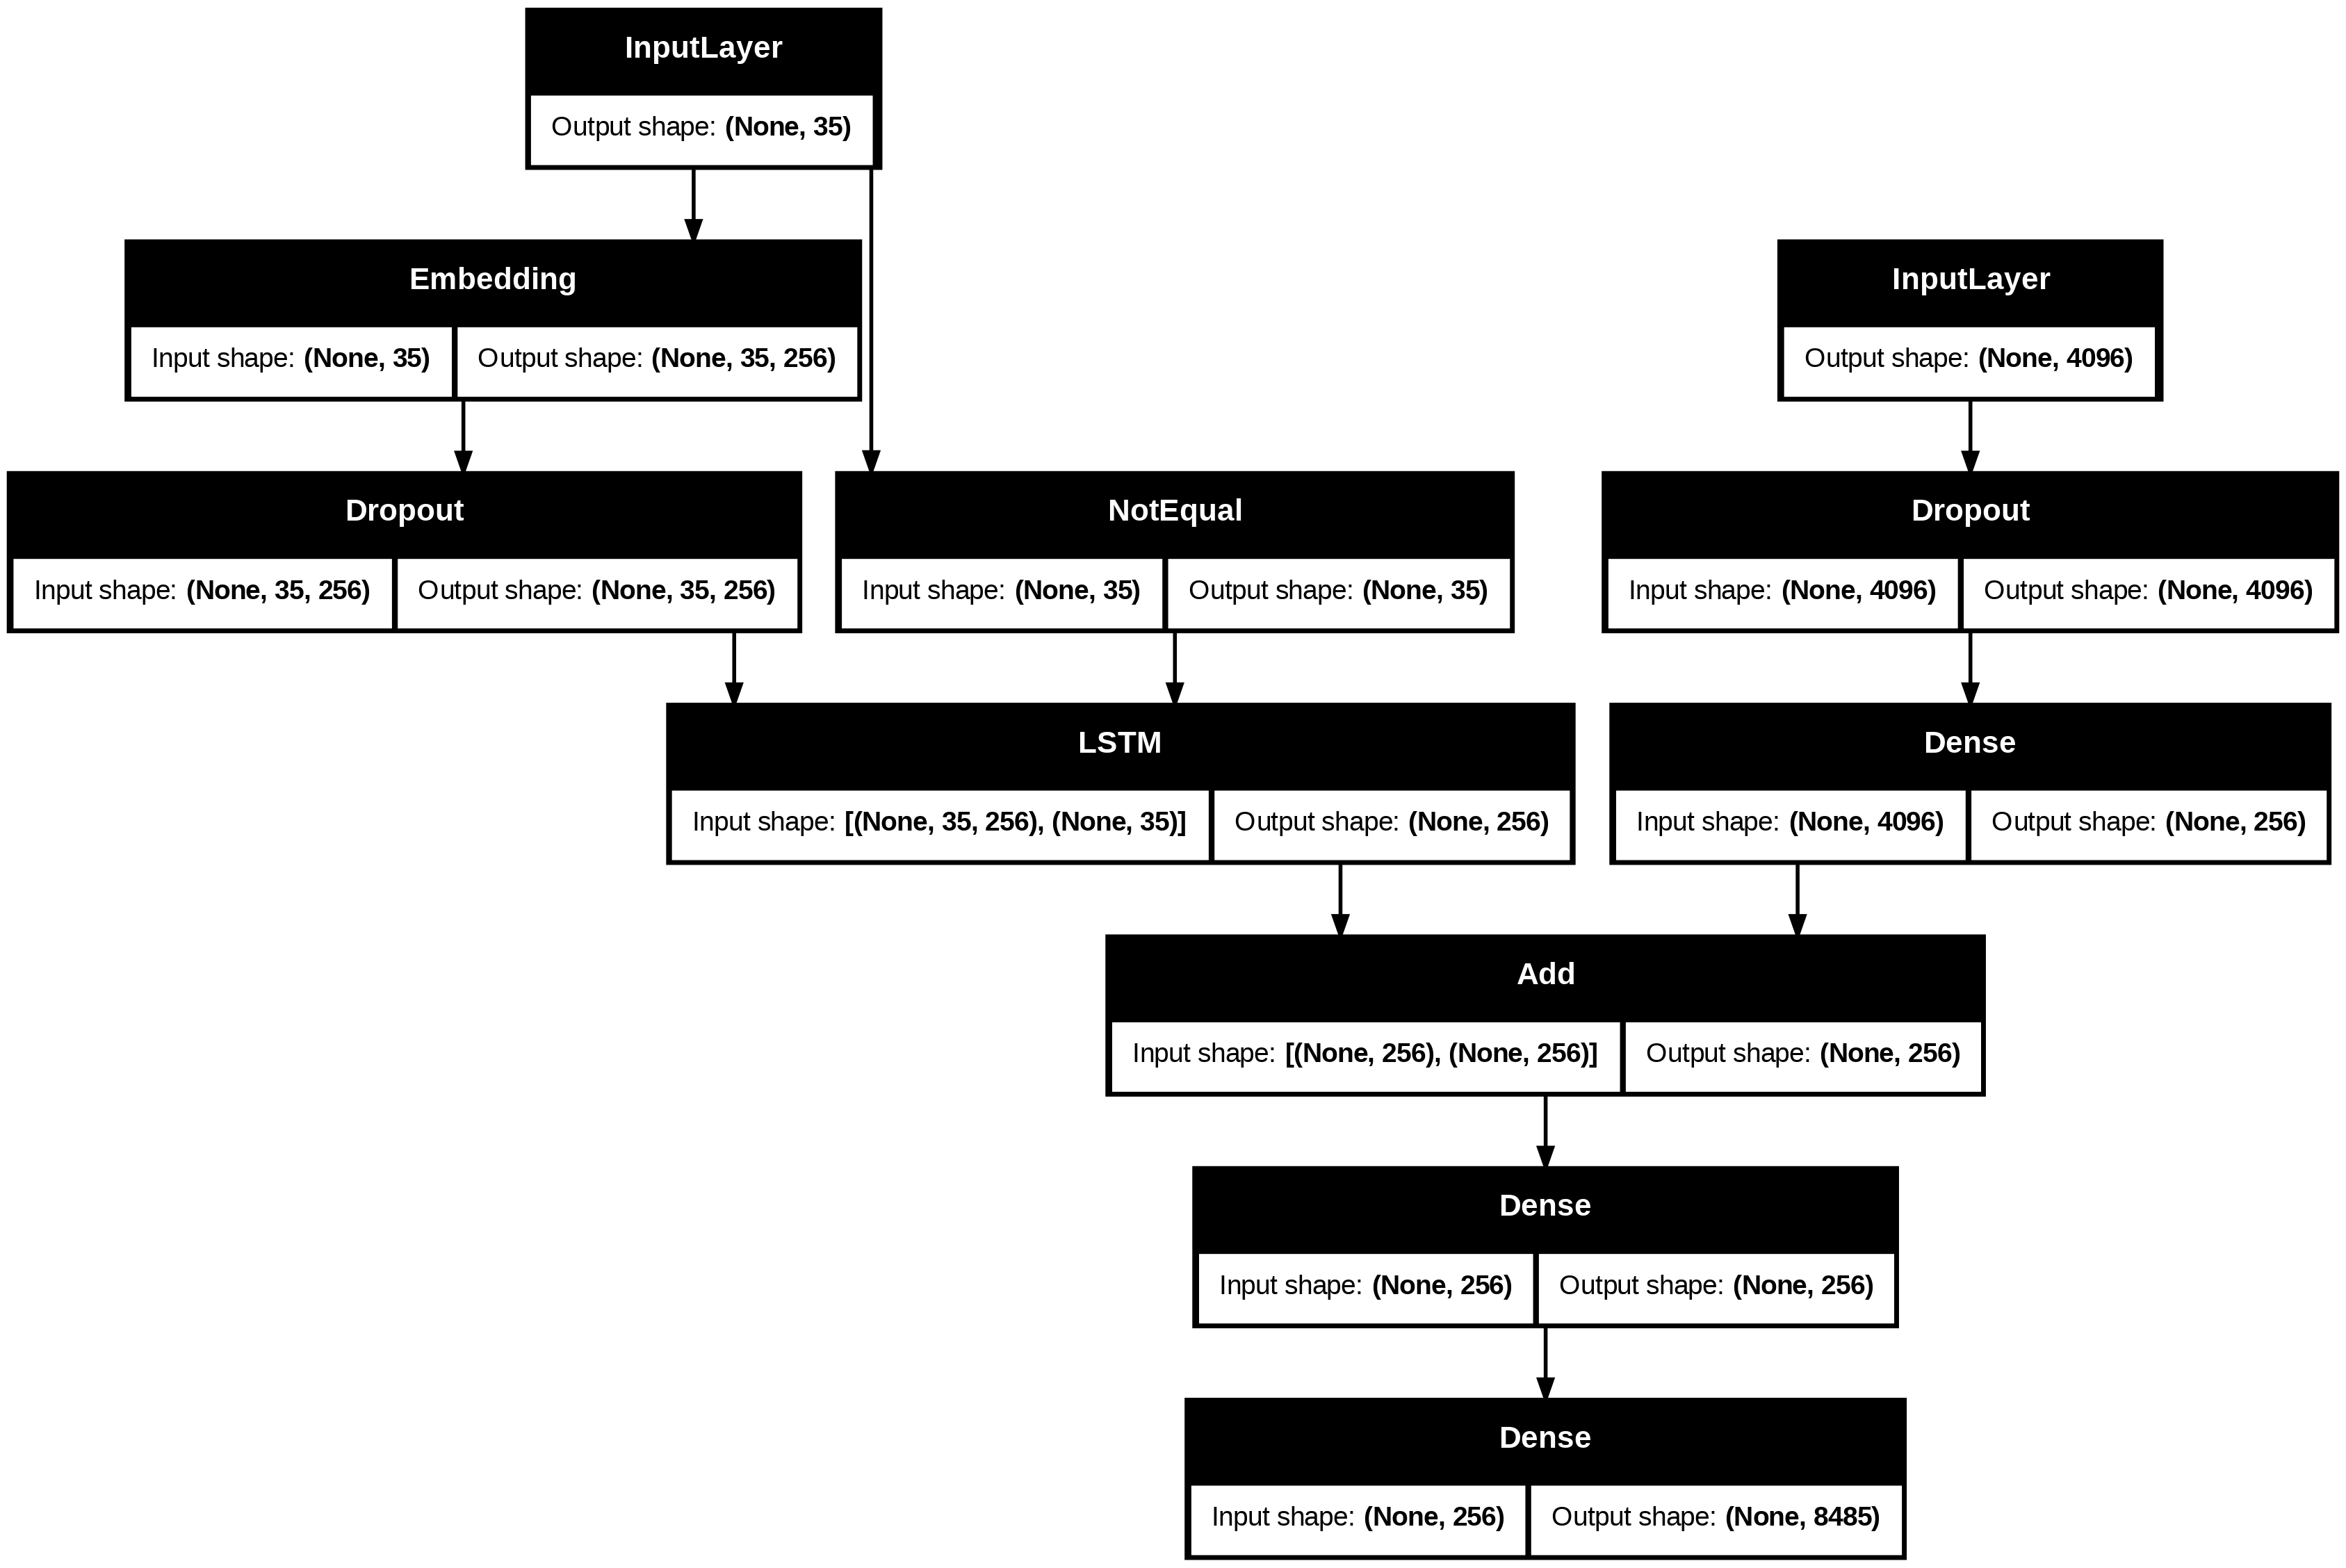

In [51]:
#encoder model
#Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)
#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot the model
plot_model(model, show_shapes=True)

In [52]:
import tensorflow as tf

output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1: Image features
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2: Input sequence
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y: Output sequence (one-hot encoded)
)

In [63]:
# Set training parameters
epochs = 20
batch_size = 32
steps = len(train) // batch_size  # Calculate the number of steps per epoch

# Create the data generator
generator = lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Wrap the generator with tf.data.Dataset.from_generator, providing the output_signature
dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

# Training loop
for epoch in range(epochs):
    # Fit the model for one epoch
    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - loss: 3.0712
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 2.7933
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 2.7244
227/227 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - loss: 2.5696
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 2.3569
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 2.2563
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 2.1486
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 2.1030
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 2.0962
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 2.0272
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 2.0200
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 1.9986
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 1.9662
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 1.8860
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 1.9195
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 1.8480
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 1.8395
227/227 ━━━━━━━━━━

In [64]:
#save the model
model.save(os.path.join(BASE_DIR, 'best_model.h5'))

## Generate caption for the image

> Add blockquote

> Add blockquote





In [65]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [66]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  in_text = 'startseq'
  for i in range(max_length):
    #encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    #pad the sequence
    sequence = pad_sequences([sequence], maxlen=max_length)[0]
    #predict next word
    yhat = model.predict([image.reshape(1, -1), sequence.reshape(1, -1)], verbose=0)
    #get index with high probability
    yhat = np.argmax(yhat)
    #convert index to word
    word = idx_to_word(yhat, tokenizer)
    #stop if word not found
    if word is None:
      break
    #append word as input for generating next word
    in_text += " " + word
    #stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

In [67]:
from nltk.translate.bleu_score import corpus_bleu
#validate the test data
actual, predicted = list(), list()
for key in tqdm(test):
  #get actual caption
  captions = mapping[key]
  #predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  #append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

from nltk.translate.bleu_score import corpus_bleu
#validate the test data
actual, predicted = list(), list()
for key in tqdm(test):
  #get actual caption
  captions = mapping[key]
  #predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  #append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.382760
BLEU-2: 0.167346


In [68]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  #load the image
  image_id = image_name.split('.')[0]
  img_path = os.path.join(BASE_DIR, 'Images', image_name)
  image = Image.open(img_path)
  captions = mapping[image_id]
  print('........Actual.........')
  for caption in captions:
    print(caption)
  #predict caption
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  print('........Predicted.........')
  print(y_pred)
  plt.imshow(image)




........Actual.........
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
........Predicted.........
startseq two dogs are looking at pavement endseq


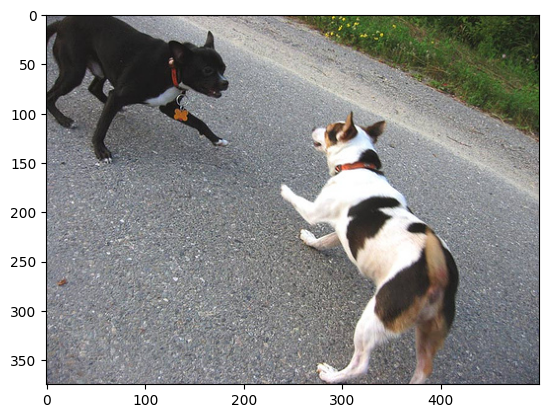

In [69]:
image_name = '1001773457_577c3a7d70.jpg'
generate_caption(image_name)

........Actual.........
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
........Predicted.........
startseq little girl covered in paint painting with fingerpaints in front of fingerpaints in front of rainbow with fingerpaints in front of rainbow with fingerpaints in front of rainbow with fingerpaints in front of rainbow with


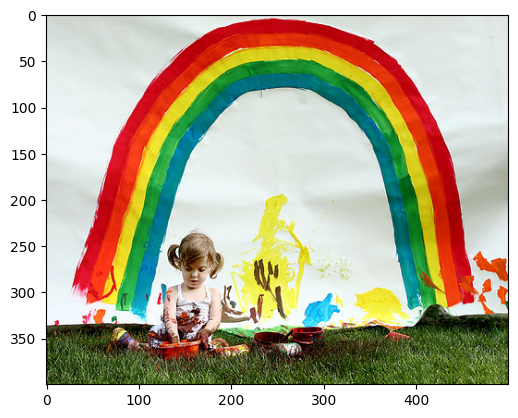

In [70]:
image_name = '1002674143_1b742ab4b8.jpg'
generate_caption(image_name)

........Actual.........
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
........Predicted.........
startseq man sleeping on his white and white and white and man is holding the black and man is holding the black man and man is holding the black man endseq


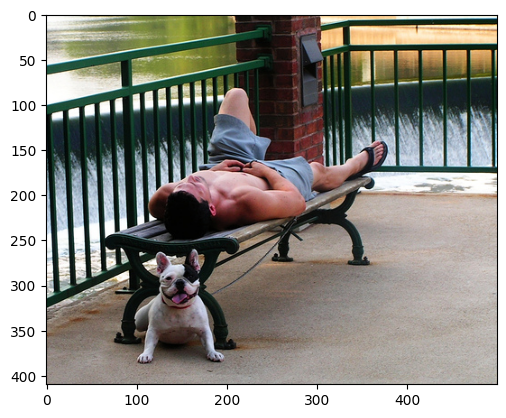

In [71]:
image_name = '1003163366_44323f5815.jpg'
generate_caption(image_name)

........Actual.........
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
........Predicted.........
startseq black and white dog is running in the grass endseq


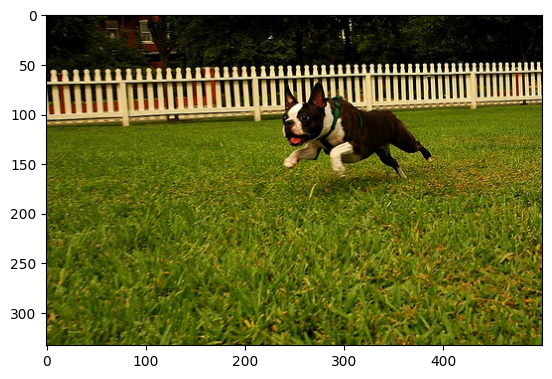

In [72]:
image_name = '1009434119_febe49276a.jpg'
generate_caption(image_name)

........Actual.........
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
........Predicted.........
startseq person in blue displaying pictures in the snow in the snow endseq


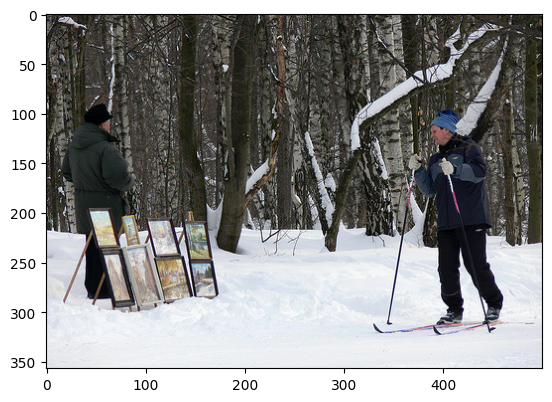

In [73]:
image_name = '101669240_b2d3e7f17b.jpg'
generate_caption(image_name)

........Actual.........
startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq "two people are at the edge of lake facing the water and the city skyline ." endseq
........Predicted.........
startseq young boy at the water with duck in the water endseq


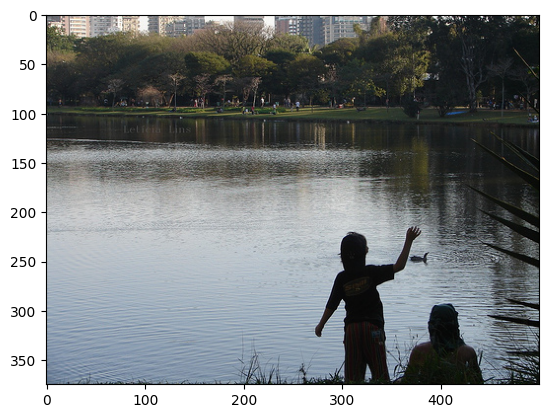

In [74]:
image_name = '1022454332_6af2c1449a.jpg'
generate_caption(image_name)